In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [16]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [17]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [18]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

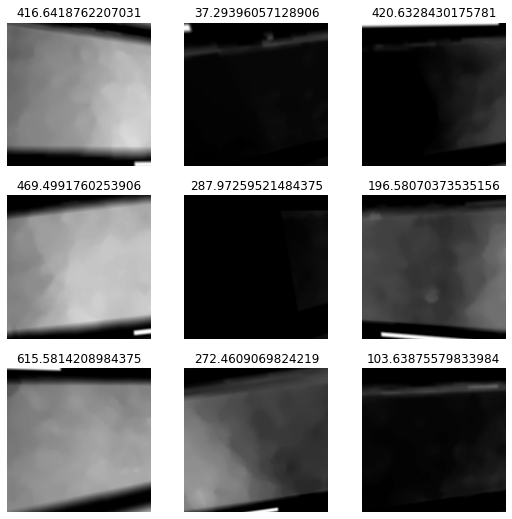

In [19]:
dls.show_batch()

In [20]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='convnext_base_Masa_Height')
]

In [21]:
from fastai.metrics import mae,rmse,mse

In [22]:
learn = Learner(dls, timm.create_model('convnext_base',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [23]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,108207.601562,122751.078125,279.018738,350.358490,122751.078125,00:05


Better model found at epoch 0 with valid_loss value: 122751.078125.


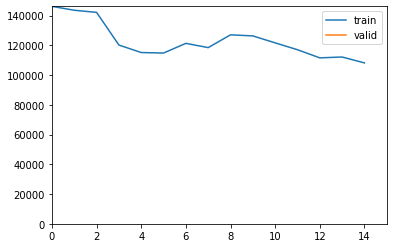

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,105828.570312,122191.453125,278.012451,349.558960,122191.453125,00:05
1,105846.648438,121637.671875,277.013855,348.765930,121637.671875,00:05
2,105322.914062,121330.304688,276.456360,348.325012,121330.304688,00:05
3,105074.023438,121032.539062,275.917297,347.897278,121032.539062,00:05
4,104668.007812,120726.750000,275.362610,347.457550,120726.750000,00:05
5,104251.664062,120412.992188,274.792297,347.005737,120412.992188,00:05
6,104035.460938,120087.937500,274.199677,346.537048,120087.937500,00:05
7,104003.968750,119757.500000,273.596985,346.059967,119757.500000,00:05
8,103290.179688,119411.617188,272.964172,345.559875,119411.617188,00:06
9,103558.656250,119062.304688,272.323547,345.054047,119062.304688,00:05


Better model found at epoch 0 with valid_loss value: 122191.453125.


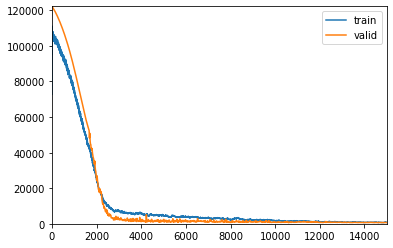

Better model found at epoch 1 with valid_loss value: 121637.671875.
Better model found at epoch 2 with valid_loss value: 121330.3046875.
Better model found at epoch 3 with valid_loss value: 121032.5390625.
Better model found at epoch 4 with valid_loss value: 120726.75.
Better model found at epoch 5 with valid_loss value: 120412.9921875.
Better model found at epoch 6 with valid_loss value: 120087.9375.
Better model found at epoch 7 with valid_loss value: 119757.5.
Better model found at epoch 8 with valid_loss value: 119411.6171875.
Better model found at epoch 9 with valid_loss value: 119062.3046875.
Better model found at epoch 10 with valid_loss value: 118696.8203125.
Better model found at epoch 11 with valid_loss value: 118323.765625.
Better model found at epoch 12 with valid_loss value: 117943.2265625.
Better model found at epoch 13 with valid_loss value: 117555.234375.
Better model found at epoch 14 with valid_loss value: 117159.0390625.
Better model found at epoch 15 with valid_loss

Better model found at epoch 123 with valid_loss value: 36895.12890625.
Better model found at epoch 124 with valid_loss value: 35909.37890625.
Better model found at epoch 125 with valid_loss value: 33810.6953125.
Better model found at epoch 126 with valid_loss value: 33438.90234375.
Better model found at epoch 128 with valid_loss value: 31828.84765625.
Better model found at epoch 129 with valid_loss value: 30148.615234375.
Better model found at epoch 130 with valid_loss value: 29403.611328125.
Better model found at epoch 131 with valid_loss value: 26926.70703125.
Better model found at epoch 132 with valid_loss value: 25655.65234375.
Better model found at epoch 133 with valid_loss value: 24281.375.
Better model found at epoch 136 with valid_loss value: 23040.94140625.
Better model found at epoch 137 with valid_loss value: 21414.669921875.
Better model found at epoch 138 with valid_loss value: 19182.916015625.
Better model found at epoch 140 with valid_loss value: 17742.841796875.
Better 

In [24]:
learn.fine_tune(1000,base_lr=1e-3)

In [25]:
# learn.load('convnext_base_Masa_Height')

In [26]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [27]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [28]:
dlstest = dbtest.dataloaders(path,bs=8)

In [29]:
learn.dls=dlstest

In [30]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 23.4683780670166.


(#4) [1005.8242797851562,23.4683780670166,31.714733123779297,1005.8242797851562]

In [31]:
from sklearn.metrics import mean_absolute_error

In [32]:
preds,gt = learn.tta()

In [33]:
mean_absolute_error(gt,preds)

22.357332